<a href="https://colab.research.google.com/github/s-c-soma/AdvanceDeeplearning-CMPE-297/blob/master/Practice/Assignment_4d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototype Networks

##Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


##Import Omniglot dataset

The Omniglot dataset is taken on [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [3]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2020-10-30 06:50:39--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2020-10-30 06:50:40--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.1s    

2020-10-30 06:50:41 (51.0 MB/s) - ‘images_evaluation.zip’ saved [646288

In [4]:
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

##Read data

The Omniglot dataset contains 1,623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people (so 20 examples per character).
It is split into a background set of 30 alphabets and an evaluation set of 20 alphabets. We will use the background set for training and the evaluation set for testing.

In [6]:
def read_alphabets(alphabet_directory_path, alphabet_directory_name):
    """
    Reads all the characters from a given alphabet_directory
    """
    datax = []
    datay = []
    characters = os.listdir(alphabet_directory_path)
    for character in characters:
        images = os.listdir(alphabet_directory_path + character + '/')
        for img in images:
            image = cv2.resize(
                cv2.imread(alphabet_directory_path + character + '/' + img),
                (28,28)
                )
            #rotations of image
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            datax.extend((image, rotated_90, rotated_180, rotated_270))
            datay.extend((
                alphabet_directory_name + '_' + character + '_0',
                alphabet_directory_name + '_' + character + '_90',
                alphabet_directory_name + '_' + character + '_180',
                alphabet_directory_name + '_' + character + '_270'
            ))
    return np.array(datax), np.array(datay)

def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_alphabets,
                          args=(
                              base_directory + '/' + directory + '/', directory, 
                              )) for directory in os.listdir(base_directory)]
    pool.close()
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [7]:
%%time 
trainx, trainy = read_images('images_background')

CPU times: user 758 ms, sys: 400 ms, total: 1.16 s
Wall time: 33.2 s


In [8]:
%%time 
testx, testy = read_images('images_evaluation')

CPU times: user 369 ms, sys: 279 ms, total: 648 ms
Wall time: 22.7 s


In [9]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((77120, 28, 28, 3), (77120,), (52720, 28, 28, 3), (52720,))

The training set contains 77,120 images (from 964 * 4 = 3,856 characters in images_background) and the testing set contains 52,720 images (from 659 * 4 = 2,636 characters in images_evaluation).

##Create samples

In [10]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [11]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


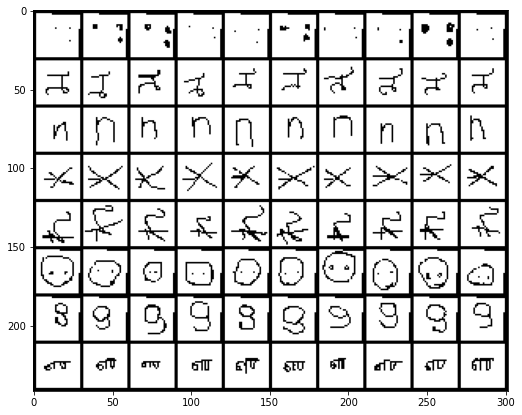

In [12]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [13]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

##Build model

The embedding part takes a (28x28x3) image and returns a column vector of length 64. The image2vector function is composed of 4 modules. Each module comprises a 64-filter 3 × 3 convolution, a batch normalization layer, a ReLU nonlinearity and a 2 × 2 max-pooling layer. 

When applied to the 28 × 28 Omniglot images this architecture results in a 64-dimensional output space.

In [14]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )
    
  return ProtoNet(encoder)

In [15]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
    
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [16]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

##Train

In [17]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [18]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

epoch size reduced for time concern

In [20]:
%%time

model = load_protonet_conv(
    x_dim=(3,28,28),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 5#2000

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Epoch 1 -- Loss: 1.9092 Acc: 0.5420



Epoch 2 -- Loss: 0.9518 Acc: 0.7220



Epoch 3 -- Loss: 0.8120 Acc: 0.7520



Epoch 4 -- Loss: 0.6379 Acc: 0.8120



Epoch 5 -- Loss: 0.7067 Acc: 0.7960
CPU times: user 3.49 s, sys: 102 ms, total: 3.59 s
Wall time: 3.14 s


##Test

In [21]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [22]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  from ipykernel import kernelapp as app



Test results -- Loss: 0.1165 Acc: 0.9564


##Test on specific example

Let's test the model on a specific example to visualize how well does it label the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


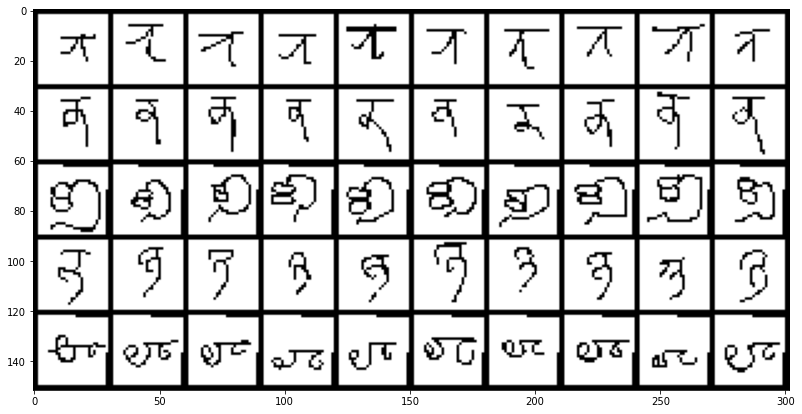

In [23]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [24]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [25]:
my_output

{'acc': 0.9199999570846558,
 'loss': 0.2212420403957367,
 'y_hat': tensor([[0, 0, 0, 0, 0],
         [1, 0, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [1, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]], device='cuda:0')}

# Matching Networks Using Tensorflow

## Import Libraries

In [27]:
!pip3 install torch torchvision
!pip3 install comet_ml

     |████████████████████████████████| 235kB 8.6MB/s 
     |████████████████████████████████| 399kB 15.9MB/s 
     |████████████████████████████████| 204kB 22.5MB/s 
  Created wheel for dulwich: filename=dulwich-0.20.8-cp36-cp36m-linux_x86_64.whl size=495678 sha256=7a65bc2011d89c099af3fedbbbb9584cdc11e97b90b7d57e860ffd3384c18993
  Stored in directory: /root/.cache/pip/wheels/d0/9d/ac/ac5168250ea01d469e4b7a7444b3f336cc05fb08feafbd5d46
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34547 sha256=61c41d1f5b1ab386a83fa506d3eb58279ddaacac9264d8d8c2b46cf5e9844da5
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built dulwich configobj


In [28]:
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model Artictechture

In [29]:
class ConvLayerWithBatchNorm(nn.Module):
  
  def __init__(self, in_channels, out_channels=64, kernel_size=3, padding=1, dropout_probality=0.2):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
    self.ReLU = nn.ReLU()
    self.batch_norm_layer = nn.BatchNorm2d(out_channels)
    self.maxpool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(dropout_probality) # Dropout to add regularization and improve model generalization
    
  def forward(self, X):
    x = self.conv(X)
    x = self.ReLU(x)
    x = self.batch_norm_layer(x)
    x = self.maxpool(x)
    x = self.dropout(x)
    return x

## Embedding Layer

In [30]:
class ConvEmbedding(nn.Module):
  
  def __init__(self, in_channels=1, embedding_size=256, dropout_probality=0.2):
    super().__init__()
    self.conv1 = ConvLayerWithBatchNorm(in_channels, 64, dropout_probality=dropout_probality)
    self.conv2 = ConvLayerWithBatchNorm(64, 64, dropout_probality=dropout_probality)
    self.conv3 = ConvLayerWithBatchNorm(64, 64, dropout_probality=dropout_probality)
    self.conv4 = ConvLayerWithBatchNorm(64, 64, dropout_probality=dropout_probality)
    self.dense = nn.Linear(64, embedding_size)
    self.dropout = nn.Dropout(dropout_probality) # Dropout to add regularization and improve model generalization
    self.embedding_size = embedding_size
  
  def forward(self, X):
    # Input shape is (batch_size, 1, 28, 28)
    x = self.conv1(X) # x's Shape (batch_size, 64, 14, 14)
    x = self.conv2(x) # x's Shape (batch_size, 64, 7, 7)
    x = self.conv3(x) # x's Shape (batch_size, 64, 3, 3)
    x = self.conv4(x) # x's Shape (batch_size, 64, 1, 1)
    x = x.view(x.size()[0], -1) # x's Shape (batch_size, 64)
    x = self.dense(x) # x's Shape (batch_size, embedding_size)
    x = self.dropout(x) # x's Shape (batch_size, embedding_size) with a few activations flipped to 0
    return x

## Fully Conditional Embedding-Target Image

In [31]:
class FullyConditionalEmbeddingTargetImage(nn.Module):
  
  def __init__(self, embedding_size, processing_steps=10):
    super().__init__()
    self.lstm_cell = torch.nn.LSTMCell(embedding_size, embedding_size)
    self.processing_steps = processing_steps
    self.embedding_size = embedding_size
    self.attn_softmax = nn.Softmax(dim=1)
  def forward(self, target_image_encoded, support_images_encoded):
    batch_size, num_images, _ = support_images_encoded.shape
    
#     hidden_state_prev = torch.zeros(batch_size, self.embedding_size).to(device)
    cell_state_prev = torch.zeros(batch_size, self.embedding_size).to(device)
    hidden_state_prev = torch.sum(support_images_encoded, dim=1) / num_images
    for i in range(self.processing_steps):
      hidden_out, cell_out = self.lstm_cell(target_image_encoded, (hidden_state_prev, cell_state_prev))
      hidden_out = hidden_out + target_image_encoded
      attn = self.attn_softmax(torch.bmm(support_images_encoded, hidden_out.unsqueeze(2)))
      attended_values = torch.sum(attn * support_images_encoded, dim=1)
      hidden_state_prev = hidden_out + attended_values
      cell_state_prev = cell_out
    
    return hidden_out

## Fully Conditional Embedding-Support Image

In [33]:
class FullyConditionalEmbeddingSupportImages(nn.Module):
  
  def __init__(self, embedding_size):
    super().__init__()
    self.embedding_size = embedding_size
    self.bidirectionalLSTM = nn.LSTM(input_size=embedding_size, hidden_size=embedding_size, bidirectional=True, batch_first=True)
  
  def initialize_hidden(self, batch_size):
    #Initialize the states needed for our bi-directional LSTM
    hidden_state = torch.zeros(2, batch_size, self.embedding_size).to(device)
    cell_state = torch.zeros(2, batch_size, self.embedding_size).to(device)
    return (hidden_state, cell_state)
  
  def forward(self, support_embeddings):
    batch_size, num_images, _ = support_embeddings.shape
    # Initialize states
    lstm_states = self.initialize_hidden(batch_size)
    # Get the LSTM Outputs
    support_embeddings_contextual, internal_states = self.bidirectionalLSTM(support_embeddings, lstm_states)
    # Get the forward and backward outputs
    support_embeddings_contextual = support_embeddings_contextual.view(batch_size, num_images, 2, self.embedding_size)
    # Add the forward and backward outputs
    support_embeddings_contextual = torch.sum(support_embeddings_contextual, dim=2)
    # Add the skip connection to our output
    support_embeddings_contextual = support_embeddings_contextual + support_embeddings
    return support_embeddings_contextual

## Cosine Distance Module

In [34]:

class CosineDistance(nn.Module):
  
  def __init__(self):
    super().__init__()
  
  def forward(self, target_image, support_images):
    support_images_normed = F.normalize(support_images, p=2, dim=2)
    # the 'p=2' param represents squared norm
    target_image_normed = F.normalize(target_image, p=2, dim=1)
    target_image_normed = target_image_normed.unsqueeze(dim=1).permute(0, 2, 1)
    # This will cause the dimensions to be [5, 64, 1]
    similarities = torch.bmm(support_images_normed, target_image.unsqueeze(1).permute(0, 2, 1))
    # torch.bmm = batch matrix multiply
    # [5, 20, 64] @ [5, 64, 1]
    # the output shape is [5, 20, 1]
    similarities = similarities.squeeze(dim=2)
    # remove last dimension
    return similarities

## One Hot Converter Module

In [35]:
# Taken from @activatedgeeks's answer from https://stackoverflow.com/questions/44461772/creating-one-hot-vector-from-indices-given-as-a-tensor
class ConvertOneHot(nn.Module):
  def __init__(self):
    super().__init__()
  
  def forward(self, labels, num_classes):
    batch_size, num_images, _ = labels.size()
    one_hot_labels = torch.Tensor(batch_size, num_images, num_classes).to(labels.device).float().zero_()
    return one_hot_labels.scatter(2, labels, 1)

## Matching Network

In [36]:
class MatchingNet(nn.Module):
  
  def __init__(self, image_shape, embedding_size=256, dropout_probality=0.2, use_fce=True):
    super().__init__()
    self.attn = nn.Softmax(dim=1)
    self.embedding = ConvEmbedding(embedding_size=embedding_size, dropout_probality=dropout_probality)
    self.distance = CosineDistance()
    self.use_fce = use_fce
    self.onehotconverter = ConvertOneHot()
    if self.use_fce:
      self.full_conditional_embedding_support = FullyConditionalEmbeddingSupportImages(embedding_size=embedding_size)
      self.full_conditional_embedding_target = FullyConditionalEmbeddingTargetImage(embedding_size=embedding_size)
    self.image_shape = image_shape
  
  def forward(self, support_images, support_labels, target_image):

    batch_size, num_images, _ = support_labels.size()

    # Get the image encodings from convolutional embedding
    target_image_encoded = self.embedding(target_image)
    support_images_encoded = self.embedding(support_images.view(-1, *self.image_shape)).view(-1, num_images, self.embedding.embedding_size)
    
    if self.use_fce:
      # Get the support images embedding with context
      support_images_encoded = self.full_conditional_embedding_support(support_images_encoded)

      # Get the target image embedding with context
      target_image_encoded = self.full_conditional_embedding_target(target_image_encoded, support_images_encoded)
    
    # Get the cosine distances between target image and the support images
    distances = self.distance(target_image_encoded, support_images_encoded)
    
    # Get the attention value based on the distances
    attention = self.attn(distances)
    
    # Convert the labels into one hot vectors
    support_set_one_hot_labels = self.onehotconverter(support_labels, num_images)
    
    # Get the prediction logits by attention * one-hot-labels (automatically summed due to the unsqueeze operation)
    prediction_logits = torch.bmm(attention.unsqueeze(1), support_set_one_hot_labels).squeeze()
    
    # Get the final labels for predictions
    _, prediction_labels = torch.max(prediction_logits, 1)
    return prediction_logits, prediction_labels

## Testing Model

In [37]:
img_shape = (1, 28, 28)
matching_net_trial = MatchingNet(img_shape, dropout_probality=0.1, use_fce=False)
print("Model Summary")
print(matching_net_trial)
epochs = 10

support_images = torch.rand(32, 20, *img_shape)
target_image = torch.rand(32, *img_shape)
support_labels = torch.LongTensor(32, 20, 1) % 20
target_labels = torch.LongTensor(32) % 20

matching_net_trial.to(device)
support_images = support_images.to(device)
support_labels = support_labels.to(device)
target_image = target_image.to(device)
target_labels = target_labels.to(device)
optimizer = torch.optim.Adam(matching_net_trial.parameters(), lr=0.001)
for epoch in range(epochs):
  logits, predictions = matching_net_trial(support_images, support_labels,target_image)
  loss = F.cross_entropy(logits, target_labels)
  print(loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Model Summary
MatchingNet(
  (attn): Softmax(dim=1)
  (embedding): ConvEmbedding(
    (conv1): ConvLayerWithBatchNorm(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ReLU): ReLU()
      (batch_norm_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv2): ConvLayerWithBatchNorm(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ReLU): ReLU()
      (batch_norm_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv3): ConvLayerWithBatchNorm(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ReLU): ReLU()
   

## Loading Data

In [74]:
!git clone --depth 1 https://github.com/brendenlake/omniglot.git
!unzip -qq omniglot/python/images_background.zip
!unzip -qq omniglot/python/images_evaluation.zip

fatal: destination path 'omniglot' already exists and is not an empty directory.
replace images_background/Alphabet_of_the_Magi/character01/0709_01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace images_evaluation/Angelic/character01/0965_01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [75]:

from skimage import io, transform
import numpy as np

def read_image(path, size, angle=0):
  img = io.imread(path, as_grey=True)
  img = transform.resize(img, size, mode='constant')
#   img = 1 - np.expand_dims(img, 0)
  img = np.expand_dims(img, 0)
  return img

def rotate(img, angle):
  return np.expand_dims(transform.rotate(np.squeeze(img), angle), 0)

In [76]:
PATH = 'images_background'
EVALUATION_PATH = 'images_evaluation'

In [ ]:

import os

def load_alphabet(path):
  lang_dict = []
  for alphabet in os.listdir(path):
    alphabet_path = os.path.join(path, alphabet)
    for letter in os.listdir(alphabet_path):
      current_letter_dict = {"alphabet": alphabet, "letter":letter, "images":[], "image_mat": []}
      letter_path = os.path.join(alphabet_path, letter)
      for letter_image in os.listdir(letter_path):
        letter_image_path = os.path.join(letter_path, letter_image)
        current_letter_dict["images"].append(letter_image_path)
        img = read_image(letter_image_path, (28, 28))
        current_letter_dict["image_mat"].append(img)
      lang_dict.append(current_letter_dict)
  return lang_dict

train_dict = load_alphabet(PATH)
test_dict = load_alphabet(EVALUATION_PATH)
print(f"found letters in Training set - {len(train_dict)}")
print(f"found letters in Testing set - {len(test_dict)}")

In [72]:
def augment_dataset(dataset):
  augmented_dataset = []
  for letter in dataset:
    for angle in range(4):
      current_letter_dict = {"alphabet": letter["alphabet"], 
                             "letter":letter["letter"], 
                             "images":letter["images"], 
                             "image_mat": []}
      for image in letter["image_mat"]:
        rotated_image = rotate(image, angle*90)
        current_letter_dict["image_mat"].append(rotated_image)
      augmented_dataset.append(current_letter_dict)
  return augmented_dataset

## Spliting Data

In [77]:
from sklearn.model_selection import train_test_split
random_state = 50
total_data = train_dict + test_dict
training_dict, testing_dict = train_test_split(total_data, test_size=0.25, random_state=random_state)
training_dict, dev_dict = train_test_split(training_dict, test_size=0.1, random_state=random_state)

print(f"Total Dataset size - {len(total_data)}")
print(f"Training Dataset size - {len(training_dict)}")
print(f"Dev Dataset size - {len(dev_dict)}")
print(f"Testing Dataset size - {len(testing_dict)}")

In [77]:
# augmented_train_dict = augment_dataset(training_dict)
# augmented_dev_dict = augment_dataset(dev_dict)
augmented_train_dict = training_dict
augmented_dev_dict = dev_dict

## Creating Task for Model

In [56]:
img_size = (28, 28)

def make_oneshot_task(dataset, nway=20):
  
  # Choose nway random letters from dataset
  letter_choices = np.random.choice(len(dataset), nway, replace=False)
  
  # Placeholders for our support dataset
  X = np.empty((nway, 1, *img_size))
  y = np.empty((nway), dtype=int)
  
  # Choose random letter from support set to be the target letter
  random_target = np.random.choice(nway, size=1)
  batch_letters = [dataset[k] for k in letter_choices]
  required_letter = None
  required_class = -1
  for i, letter in enumerate(batch_letters):
      # Choose random image from each letter
      letter_index = np.random.randint(len(letter["images"]))
      X[i,] = letter["image_mat"][letter_index]
      y[i] = i
      if(i == random_target[0]):
        # Fetching a different image for our target image from chosen letter
        required_index = (letter_index + np.random.randint(1, len(letter["images"]))) % len(letter["images"])
        required_letter = letter["image_mat"][required_index]
        required_class = i
  return X, y, required_letter, required_class

## Visualize One shot Task

In [57]:
import matplotlib.pyplot as plt

def visualize_oneshot_task(X, y, required_letter, required_class):
  fig=plt.figure(figsize=(8, 8))
  columns = 5
  rows = X.shape[0]//columns + 1
  for i in range(1, X.shape[0] + 1):
    img = X[i-1]
    fig.add_subplot(rows, columns, i).set_title(y[i-1])
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(*img_size))
  fig.add_subplot(rows, columns, X.shape[0] + 3).set_title(required_class)
  plt.imshow(required_letter.reshape(*img_size))
  plt.axis('off')
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [77]:
# Visualize our training dataset
visualize_oneshot_task(*make_oneshot_task(augmented_train_dict))

In [ ]:
# Visualize our validation/dev dataset
visualize_oneshot_task(*make_oneshot_task(augmented_dev_dict))

In [ ]:
# Visualize our test dataset
visualize_oneshot_task(*make_oneshot_task(testing_dict))

## Dataset Class

In [59]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch

class OneShotDataset(Dataset):
  
  def __init__(self, data_dict, iterations=1000):
    self.data_dict = data_dict
    self.length = iterations
  
  def __getitem__(self, index): 
    support_images, support_labels, target_image, target_label = make_oneshot_task(self.data_dict)
    return (torch.from_numpy(support_images).float(),
            torch.from_numpy(support_labels).long().unsqueeze(-1),
            torch.from_numpy(target_image).float(),
            target_label)  
  def __len__(self):
    return self.length

## Evaluate Model

In [60]:
def evaluate_model(model, dataset_dict, iterations=1000, batch_size=20):
  model.eval() # Set the model in eval mode so as ensure Dropout and BatchNorm layers operate in Evaluation mode
  
  # Set up our dataloaders
  dataset = OneShotDataset(dataset_dict, iterations=iterations)
  dataset_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                  batch_size=batch_size,
                                                  num_workers=4,                                                  
                                                  shuffle=False)
  
  # Run in no_grad mode to speed up inference 
  with torch.no_grad():
    # Placeholders to accumulate the metrics across batches
    total_accuracy = 0
    total_loss = 0
    for iteration, (support_images, support_labels, images, labels) in enumerate(dataset_loader):
      # Move Data to GPU
      support_batch_torch = support_images.to(device)
      support_labels_torch = support_labels.to(device)
      target_images_torch = images.to(device)
      target_labels_torch =labels.to(device)

      # Perform inference via our model
      logits, predictions = model(support_batch_torch, support_labels_torch, target_images_torch)
      # Calculate loss and accuracy
      loss = F.cross_entropy(logits, target_labels_torch)
      accuracy = torch.mean((predictions == target_labels_torch).float())
      
      # Accumulate the metrics
      total_loss = total_loss + loss.item()
      total_accuracy = total_accuracy + accuracy.item()
      
    accuracy = total_accuracy/(iteration+1)
    loss = total_loss/(iteration+1)
    return accuracy, loss

### Baseline KNN Accuracy

In [61]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_one_shot_performance(dataset, nway=20, num_tests=300):
  correct = 0
  for i in range(num_tests):
    support_set, support_labels, required_letter, required_label = make_oneshot_task(dataset, nway=nway)
    images = np.insert(support_set, 0, required_letter, axis=0)
    # Baseline model with just l2 Distance between images
    embeddings = images.reshape(nway+1, -1)
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(embeddings[1:], support_labels)
    prediction = neigh.predict(embeddings[:1])
    if(prediction[0] == required_label):
      correct = correct + 1
  print(f"Accuracy - {correct * 100 / num_tests}%")

In [77]:
evaluate_one_shot_performance(testing_dict, nway=20, num_tests=500)

## Training Model

In [63]:
epochs = 43 #@param {type: "slider", min: 1, max: 100}
batch_size = 20 #@param {type: "slider", min: 20, max: 200}
iterations = 10000 #@param {type: "slider", min: 500, max: 10000}
lr = 0.0001 #@param ["0.1", "0.01", "0.001", "0.0001"] {type:"raw", allow-input: true}
embedding_size = 64 #@param {type: "slider", min: 64, max: 512}
dropout_probality=0.1 #@param {type: "slider", min: 0, max: 1, step: 0.1}
use_fce = True #@param ["True", "False"] {type:"raw"}

In [77]:
pytorch_experiment = Experiment(api_key="SCmpLSERj7defIsfWhQcs7D4E",
                        project_name="PyTorch Matching Net", workspace="ramesharvind")

In [ ]:
pytorch_experiment.log_multiple_params({"Epochs":epochs, "Batch Size": batch_size, "Iterations Per Epoch": iterations, "Learning Rate": lr, "Embedding Size": embedding_size, "Dropout": dropout_probality, "Using FCE": use_fce})

## Training Loop

In [65]:
# Define the model
matching_net = MatchingNet(img_shape, embedding_size=embedding_size, dropout_probality=dropout_probality, use_fce=use_fce)
print("Model Summary")
print(matching_net)

Model Summary
MatchingNet(
  (attn): Softmax(dim=1)
  (embedding): ConvEmbedding(
    (conv1): ConvLayerWithBatchNorm(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ReLU): ReLU()
      (batch_norm_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv2): ConvLayerWithBatchNorm(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ReLU): ReLU()
      (batch_norm_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv3): ConvLayerWithBatchNorm(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ReLU): ReLU()
   

In [77]:
# Move the model to GPU
matching_net.to(device)
# Create the optimizer
optimizer = torch.optim.Adam(matching_net.parameters(), lr=lr)
# placeholders to store our best performing metrics on Dev Set
best_dev_loss = 0
best_dev_accuracy = 0

print("Beginning Training..")

for epoch in range(epochs):
  matching_net.train() # Set our model in train mode

  # Placeholder variables to help track epoch loss and accuracy
  total_loss = 0
  total_accuracy = 0
  
  # Define our dataset and dataloader 
  train_dataset = OneShotDataset(augmented_train_dict, iterations)
  train_dataset_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                  batch_size=batch_size,
                                                  num_workers=4,
                                                  shuffle=False)
  # Main training loop
  for iteration, (support_images, support_labels, images, labels) in enumerate(train_dataset_loader):
    # Move our data to GPU
    support_batch_torch = support_images.to(device)
    support_labels_torch = support_labels.to(device)
    target_images_torch = images.to(device)
    target_labels_torch =labels.to(device)
    # Get the predictions and logits from our model
    logits, predictions = matching_net(support_batch_torch, support_labels_torch, target_images_torch)
    
    # Calculate loss and accuracy in current iteration
    loss = F.cross_entropy(logits, target_labels_torch)
    accuracy = torch.mean((predictions == target_labels_torch).float())
    
    # Accumulate the values
    total_loss = total_loss + loss.item()
    total_accuracy = total_accuracy + accuracy.item()

    # Perform Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  total_accuracy = total_accuracy/(iteration+1)
  total_loss = total_loss/(iteration+1)
  
  # Log the training metrics to comet.ml
  with pytorch_experiment.train():
    pytorch_experiment.log_current_epoch(epoch)
    pytorch_experiment.log_metric("loss",total_loss)
    pytorch_experiment.log_metric("accuracy",total_accuracy)
  print(f"In epoch - {epoch} Train Set - Accuracy {total_accuracy} Loss - {total_loss} - for {(iteration+1)} iterations")
  
  
  # Run the model on Dev Set to evaluate performance on unseen data (every 3 epochs)
  if epoch%3 == 0:
    with pytorch_experiment.validate():
      pytorch_experiment.log_current_epoch(epoch)
      dev_accuracy, dev_loss = evaluate_model(matching_net, augmented_dev_dict)
      print(f"--In epoch - {epoch} Dev Set Accuracy - {dev_accuracy} Loss - {dev_loss}")
      
      # Save the best performing model across all the epochs
      if not best_dev_loss or dev_loss < best_dev_loss:
        print(f"---Found Better Model to save with Accuracy - {dev_accuracy} and loss - {dev_loss}")
        best_dev_loss = dev_loss
        best_dev_accuracy = dev_accuracy
        torch.save(matching_net.state_dict(), "matching_net-%0.2f-accuracy.pt"%(best_dev_accuracy))
      
      # Log the Dev metrics to comet.ml
      pytorch_experiment.log_metric("accuracy",dev_accuracy)
      pytorch_experiment.log_metric("dev_loss",dev_loss)

## Evaluating on Testing Data

In [77]:
with pytorch_experiment.test():
  matching_net_test = MatchingNet(img_shape, embedding_size=embedding_size, dropout_probality=dropout_probality, use_fce=use_fce)
  matching_net_test.load_state_dict(torch.load("matching_net-%0.2f-accuracy.pt"%(best_dev_accuracy)))
  matching_net_test.to(device)
  test_accuracy, test_loss = evaluate_model(matching_net_test, testing_dict, iterations=5000)
  pytorch_experiment.log_metric("accuracy",test_accuracy)
  pytorch_experiment.log_metric("test_loss",test_loss)
  print(f"Test Set Accuracy - {test_accuracy} Loss - {test_loss}")
pytorch_experiment.end()

## Pre-trained Models

In [68]:

!git clone https://github.com/RameshArvind/Pytorch-Matching-Networks.git

fatal: destination path 'Pytorch-Matching-Networks' already exists and is not an empty directory.


In [69]:
model_weights_with_fce = "Pytorch-Matching-Networks/matching_net-FCE-0.73-accuracy.pt"
model_weights_without_fce = "Pytorch-Matching-Networks/matching_net-WITHOUT-FCE-0.74-accuracy.pt"

## Model without FCE

In [77]:
embedding_size = 64
dropout_probality=0.1
use_fce = False

matching_net_test = MatchingNet(img_shape, embedding_size=embedding_size, dropout_probality=dropout_probality, use_fce=use_fce)
matching_net_test.load_state_dict(torch.load(model_weights_without_fce))
matching_net_test.to(device)
test_accuracy, test_loss = evaluate_model(matching_net_test, testing_dict, iterations=5000)
pytorch_experiment.log_metric("accuracy",test_accuracy)
pytorch_experiment.log_metric("test_loss",test_loss)
print(f"Without FCE - Test Set Accuracy - {test_accuracy} Loss - {test_loss}")